# Predicting a song's success taking into account the artists popularity

In [97]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

url = "https://es.wikipedia.org/wiki/Anexo:Canciones_m%C3%A1s_reproducidas_en_Spotify"

response = requests.get(url)
response.status_code # 200 status code means OK!

soup = BeautifulSoup(response.content, "html.parser")

soup

prestab = soup.select("table")[0]

prestab.select("tr td")

song = []
for title in prestab.select("tr td:nth-child(2)"):
    song.append(title.get_text())
    #print(title.get_text())

song

artist = []
for title in prestab.select("tr td:nth-child(3)"):
    artist.append(title.get_text())
    #print(title.get_text())
#mw-content-text > div.mw-parser-output > table:nth-child(9) > tbody > tr:nth-child(4) > td:nth-child(3)

artist

replays = []
for title in prestab.select("tr td:nth-child(5)"):
    replays.append(title.get_text())
    #print(title.get_text())
    

replays

song = pd.DataFrame(song)
artist = pd.DataFrame(artist)
replays = pd.DataFrame(replays)
print(len(song))
print(len(artist))
print(len(replays))

df_1 = pd.concat([replays], axis = 1)
df_1.columns = ['replays (billion)']
df_1 = df_1.replace(',','', regex=True)
df_1 = df_1.astype(float)
df_1 

## Getting access to spotify

In [98]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
#sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='<your client id here>',
#                                                           client_secret='<your client secret here>'))

In [99]:
secrets_file = open("secrets.txt","r")

In [100]:
string = secrets_file.read()

In [101]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

In [102]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

### Coding in spotify

In [103]:
from random import randint
from time import sleep

def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3))
    return tracks

In [104]:
# this will take at least around num_pages_in_playlist * (avg_sleep_time + processing_time) = 53 * (2+0.1) = 110 seconds

all_tracks = get_playlist_tracks("5Rrf7mqN8uus2AaQQQNdc1")
len(all_tracks)

500

In [105]:
def get_name_artists_from_track(track):
    return [(track["name"],artist["name"]) for artist in track["artists"]]

In [106]:
def get_name_artist_from_playlist_item(playlist_item):
    return get_name_artists_from_track(playlist_item['track'])

In [107]:
#flattening is not in the standard library but used a lot. you'll thank me later
def flatten(input_list):
    return [item for sublist in input_list for item in sublist]


In [108]:
def get_name_artists_from_playlist(input_playlist):
    return list(map(get_name_artist_from_playlist_item, input_playlist))

In [109]:
song_artist = get_name_artists_from_playlist(all_tracks)
len(song_artist)

500

In [110]:
song_artist = [song_artist[i][0] for i in range(len(song_artist))] 


In [111]:
df = pd.DataFrame(song_artist, columns = ['song', 'artist'])
df

song              artist
0                                 Like a Rolling Stone           Bob Dylan
1    (I Can't Get No) Satisfaction - Mono Version /...  The Rolling Stones
2                            Imagine - Remastered 2010         John Lennon
3                                          Purple Rain              Prince
4                                      What's Going On         Marvin Gaye
..                                                 ...                 ...
495                                    I'm Every Woman          Chaka Khan
496                             Rainy Night In Georgia        Brook Benton
497                          The Boys Are Back In Town          Thin Lizzy
498                                   Baby, I Love You             Ramones
499                                More Than a Feeling              Boston

[500 rows x 2 columns]

In [112]:
uris = [(all_tracks[i]["track"]["uri"]) for i in range(len(all_tracks))]

uris = pd.DataFrame(uris, columns = ['uri'])
uris

uri
0    spotify:track:3AhXZa8sUQht0UEdBJgpGc
1    spotify:track:57J2znxukXsXzS3XPuZ1TG
2    spotify:track:7pKfPomDEeI4TPT6EOYjn9
3    spotify:track:54X78diSLoUDI3joC2bjMz
4    spotify:track:42PyxnviKRfOa8z39g8aZj
..                                    ...
495  spotify:track:14M8Z46sA114emOXJMvyUp
496  spotify:track:1E3N0QEjPYWOxlyVScZtbW
497  spotify:track:0PQa7dlf3QyCvdQ4zc5z2Q
498  spotify:track:29imR7dda5XqwPRFmby7HS
499  spotify:track:32kgOw8wejH7zUhtXCM8DH

[500 rows x 1 columns]

In [113]:
track_pop = [(all_tracks[i]["track"]["popularity"]) for i in range(len(all_tracks))]
track_pop = pd.DataFrame(track_pop, columns = ['popularity'])
track_pop

popularity
0            68
1             0
2            75
3            72
4             0
..          ...
495          25
496          21
497          28
498          57
499           0

[500 rows x 1 columns]

In [116]:
track_pop['popularity'].max()

82

In [117]:
track_pop['popularity'] = track_pop['popularity'].astype(float)
track_pop['popularity'] = [ 1 if i>=33 else 0 for i in track_pop['popularity']]
track_pop['popularity'].value_counts()

0    357
1    143
Name: popularity, dtype: int64

In [118]:
sau_df = pd.concat([df, uris], axis = 1)
sau_df

song              artist  \
0                                 Like a Rolling Stone           Bob Dylan   
1    (I Can't Get No) Satisfaction - Mono Version /...  The Rolling Stones   
2                            Imagine - Remastered 2010         John Lennon   
3                                          Purple Rain              Prince   
4                                      What's Going On         Marvin Gaye   
..                                                 ...                 ...   
495                                    I'm Every Woman          Chaka Khan   
496                             Rainy Night In Georgia        Brook Benton   
497                          The Boys Are Back In Town          Thin Lizzy   
498                                   Baby, I Love You             Ramones   
499                                More Than a Feeling              Boston   

                                      uri  
0    spotify:track:3AhXZa8sUQht0UEdBJgpGc  
1    spotify:track:57J2znxukXsXzS3XPuZ1TG  
2    spotify:track:7pKfPomDEeI4TPT6EOYjn9  
3    spotify:track:54X78diSLoUDI3joC2bjMz  
4    spotify:track:42PyxnviKRfOa8z39g8aZj  
..                                    ...  
495  spotify:track:14M8Z46sA114emOXJMvyUp  
496  spotify:track:1E3N0QEjPYWOxlyVScZtbW  
497  spotify:track:0PQa7dlf3QyCvdQ4zc5z2Q  
498  spotify:track:29imR7dda5XqwPRFmby7HS  
499  spotify:track:32kgOw8wejH7zUhtXCM8DH  

[500 rows x 3 columns]

In [119]:
sau_df = sau_df[~ sau_df['uri'].str.contains('spotify:local')]


In [120]:
audio_features = [sp.audio_features(i) for i in sau_df['uri']]


In [121]:
audio_features = [audio_features[i][0] for i in range(len(audio_features))] 


In [122]:
af_df = pd.DataFrame.from_dict(data = audio_features, orient = 'columns').pivot_table(index = 'uri').reset_index()
#este from_dict es para hacer un data frame de un diccionario
af_df


uri  acousticness  danceability  \
0    spotify:track:00sydAz6PeOxYzwG1dRIPi       0.00353         0.235   
1    spotify:track:01cY7Cc7t5zPB64uj8NGxz       0.76000         0.445   
2    spotify:track:01jBLs7IZQzPt3dVdn5rDa       0.01580         0.605   
3    spotify:track:01nJMWcaNJ083svAa1wnRJ       0.72700         0.583   
4    spotify:track:02jqAXT2WthJJPM0q9itCr       0.39800         0.692   
..                                    ...           ...           ...   
495  spotify:track:7ugeFdykRDPMMy6XPMdIdz       0.56300         0.526   
496  spotify:track:7utRJ4BeYx85khzP3lKoBX       0.83500         0.498   
497  spotify:track:7wJepIHVDC88KzSyzNU1mA       0.80600         0.858   
498  spotify:track:7xdLNxZCtY68x5MAOBEmBq       0.00282         0.429   
499  spotify:track:7z2VrUcgL1RC2XrWiogjYJ       0.60100         0.692   

     duration_ms  energy  instrumentalness  key  liveness  loudness  mode  \
0         208133   0.977          0.006040    6    0.1720     0.878     1   
1         307667   0.486          0.000658   11    0.1890   -14.521     1   
2         335533   0.907          0.015800    0    0.0697    -3.560     1   
3         345667   0.653          0.004990    6    0.6820    -8.071     1   
4         157493   0.653          0.015200    4    0.9710   -12.382     1   
..           ...     ...               ...  ...       ...       ...   ...   
495       111536   0.728          0.000000    0    0.1590    -7.227     1   
496       271760   0.242          0.536000    9    0.1330   -12.238     1   
497       165093   0.382          0.002480   10    0.1010   -15.954     1   
498       238627   0.812          0.000024    8    0.0882    -6.252     1   
499       122773   0.379          0.000000    1    0.1950   -10.652     0   

     speechiness    tempo  time_signature  valence  
0         0.1070  152.952               4    0.241  
1         0.0616   93.019               4    0.629  
2         0.0330  117.511               4    0.965  
3         0.0525   82.129               4    0.705  
4         0.0530  111.050               4    0.831  
..           ...      ...             ...      ...  
495       0.0737   78.709               4    0.880  
496       0.0257  153.744               4    0.312  
497       0.0463  106.500               4    0.692  
498       0.0657  113.279               4    0.625  
499       0.0716   81.243               4    0.534  

[500 rows x 14 columns]

In [123]:
final_df_1 = sau_df.merge(right = af_df, on = 'uri')
final_df = pd.concat([final_df_1, track_pop], axis = 1)
final_df

song              artist  \
0                                 Like a Rolling Stone           Bob Dylan   
1    (I Can't Get No) Satisfaction - Mono Version /...  The Rolling Stones   
2                            Imagine - Remastered 2010         John Lennon   
3                                          Purple Rain              Prince   
4                                      What's Going On         Marvin Gaye   
..                                                 ...                 ...   
495                                    I'm Every Woman          Chaka Khan   
496                             Rainy Night In Georgia        Brook Benton   
497                          The Boys Are Back In Town          Thin Lizzy   
498                                   Baby, I Love You             Ramones   
499                                More Than a Feeling              Boston   

                                      uri  acousticness  danceability  \
0    spotify:track:3AhXZa8sUQht0UEdBJgpGc      0.731000         0.482   
1    spotify:track:57J2znxukXsXzS3XPuZ1TG      0.035400         0.722   
2    spotify:track:7pKfPomDEeI4TPT6EOYjn9      0.907000         0.547   
3    spotify:track:54X78diSLoUDI3joC2bjMz      0.035300         0.367   
4    spotify:track:42PyxnviKRfOa8z39g8aZj      0.403000         0.280   
..                                    ...           ...           ...   
495  spotify:track:14M8Z46sA114emOXJMvyUp      0.104000         0.539   
496  spotify:track:1E3N0QEjPYWOxlyVScZtbW      0.417000         0.512   
497  spotify:track:0PQa7dlf3QyCvdQ4zc5z2Q      0.216000         0.449   
498  spotify:track:29imR7dda5XqwPRFmby7HS      0.202000         0.735   
499  spotify:track:32kgOw8wejH7zUhtXCM8DH      0.000894         0.377   

     duration_ms  energy  instrumentalness  key  liveness  loudness  mode  \
0         369600   0.721          0.000000    0    0.1890    -6.839     1   
1         222840   0.882          0.049600    2    0.1190    -6.763     1   
2         187867   0.257          0.183000    0    0.0935   -12.358     1   
3         520787   0.452          0.002280   10    0.6890   -10.422     1   
4         233293   0.720          0.000001    1    0.3940    -9.668     0   
..           ...     ...               ...  ...       ...       ...   ...   
495       245120   0.969          0.000006    0    0.3410    -3.713     0   
496       249760   0.253          0.001840    7    0.0762   -15.793     1   
497       266467   0.700          0.000229    8    0.1820    -9.777     1   
498       224560   0.653          0.000307    8    0.0802    -5.533     1   
499       285133   0.682          0.002170    7    0.0504    -8.039     1   

     speechiness    tempo  time_signature  valence  popularity  
0         0.0321   95.263               4    0.557           1  
1         0.0348  136.299               4    0.921           0  
2         0.0252   75.752               4    0.169           1  
3         0.0307  113.066               4    0.189           1  
4         0.1110  202.523               4    0.805           0  
..           ...      ...             ...      ...         ...  
495       0.0780  114.465               4    0.652           0  
496       0.0391  137.082               4    0.326           0  
497       0.0466   80.631               4    0.786           0  
498       0.0269  107.779               4    0.930           1  
499       0.0299  108.736               4    0.288           0  

[500 rows x 17 columns]

In [124]:
singer= pd.get_dummies(final_df['artist'])


In [125]:
numericals_1 = final_df.select_dtypes(include = np.number)

In [126]:
variables = pd.concat([numericals_1, singer], axis = 1)

In [127]:
# import seaborn as sb
# import matplotlib.pyplot as plt
# import seaborn as sns 


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: vmin. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


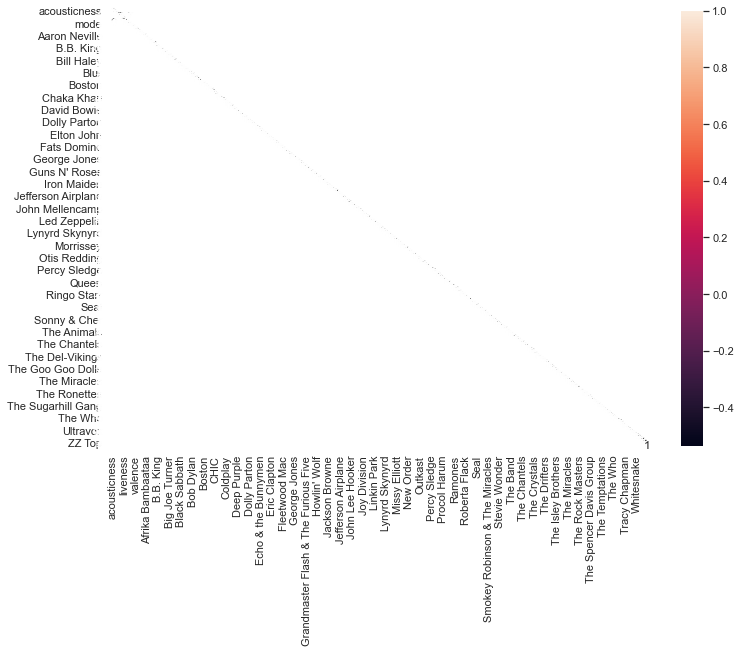

In [128]:
# correlations_matrix = variables.corr()
# sns.heatmap(correlations_matrix, sns.set(rc = {'figure.figsize':(12,8)}), linewidths=3, annot=True)
# plt.show()

In [130]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
variables.corr()



acousticness  danceability  duration_ms  \
acousticness                              1.000000     -0.048241    -0.241803   
danceability                             -0.048241      1.000000    -0.141545   
duration_ms                              -0.241803     -0.141545     1.000000   
energy                                   -0.535462     -0.052997     0.058538   
instrumentalness                         -0.115059     -0.046918     0.137034   
key                                      -0.021746     -0.035446     0.045530   
liveness                                 -0.034204     -0.216158     0.038266   
loudness                                 -0.267351     -0.056985    -0.073431   
mode                                      0.068988     -0.131716    -0.062596   
speechiness                              -0.035283      0.087950     0.017426   
tempo                                    -0.061926     -0.281690    -0.071606   
time_signature                           -0.188170      0.130403     0.006158   
valence                                  -0.125698      0.479628    -0.301262   
popularity                               -0.074601      0.039576    -0.023000   
? & The Mysterians                       -0.025283      0.005698     0.046839   
ABBA                                      0.019591      0.033574    -0.008006   
Aaron Neville                            -0.021061      0.027263    -0.038128   
Aerosmith                                -0.059000     -0.018445     0.052234   
Afrika Bambaataa                         -0.042846      0.109552     0.078943   
Al Green                                  0.017990      0.088605     0.014364   
Alanis Morissette                        -0.020852     -0.041140    -0.002673   
Alice Cooper                             -0.053504     -0.035115    -0.027485   
Archie Bell & The Drells                 -0.006136      0.019886    -0.021168   
Aretha Franklin                          -0.000895      0.089876    -0.077474   
B.B. King                                 0.049191      0.005415     0.050338   
Bad Company                              -0.029805      0.030668     0.011903   
Beck                                     -0.044534      0.011657     0.001761   
Bee Gees                                 -0.072947      0.060941     0.027850   
Ben E. King                               0.038585      0.030762    -0.034437   
Biffy Clyro                              -0.049062     -0.015867     0.014080   
Big Joe Turner                            0.069091      0.016481    -0.027109   
Big Star                                 -0.049318     -0.042256    -0.026080   
Bill Haley                                0.006376      0.037479    -0.051888   
Bill Withers                              0.071664      0.005255    -0.030493   
Billy Joel                                0.043764     -0.061835     0.055903   
Billy Preston                             0.044669      0.019318    -0.015019   
Black Sabbath                            -0.070352     -0.117461     0.112646   
Blondie                                  -0.081676      0.004637     0.000673   
Blue Swede                               -0.010358     -0.001963    -0.030636   
Blue Öyster Cult                         -0.049514     -0.053322     0.040202   
Blur                                     -0.057252      0.035783    -0.057683   
Bo Diddley                                0.033303      0.063500    -0.050966   
Bob Dylan                                 0.123695     -0.076306     0.140163   
Bob Marley & The Wailers                 -0.001452      0.084588     0.005752   
Bobbie Gentry                             0.058991      0.023575     0.012217   
Bobby Darin                               0.064870     -0.001395    -0.024654   
Bonnie Raitt                              0.077835      0.009671     0.052891   
Booker T. & the M.G.'s                    0.065925      0.074366    -0.028828   
Boston                                   -0.049570     -0.050201     